# Contribution Analysis
In this notebook, I will examine the contributions calculated by LRP. There are two kinds of different contribution scores to every gene:
* A feature contribution that tells us how important each of the features were for the classification of that gene as being a cancer gene
* A neighbor contribution that tells us which of its interacting partners in the PPI were most important for the classification of that gene

There are several strategies to make use of the LRP contributions and I would like to examine a few of them here.

In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess

# clustering & embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn

# other modules of mine
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

import sharepathway as sp

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

In [2]:
def get_hhotnet_results():
    all_clusters = []
    all_genes = []
    with open('../../hierarchical-hotnet/examples/results/clusters_mynetwork.tsv', 'r') as f:
        for line in f.readlines():
            if not line.startswith('#'): # exclude comments
                cluster = [i.strip() for i in line.split('\t')]
                if len(cluster) == 1:
                    break
                all_clusters.append(cluster)
                all_genes += cluster
    return all_clusters, all_genes


def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv('../data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, cluster_idx, out_dir):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                           os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                           genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_number)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_ylabel('Feature Contribution')
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0}  {1:.2f}  {2}  {3}  {4}'.format(i, pathways.iloc[i]['Pvalue'],
                                                                   pathways.iloc[i]['Count'],
                                                                   pathways.iloc[i]['Size'],
                                                                   pathways.iloc[i]['Term']
                                                                  )
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

## Load the Clustering Results

In [3]:
"""model_dir = '../data/GCN/training/2019_03_06_15_45_33/'
with h5py.File(os.path.join(model_dir, 'contributions_allgenes.h5'), 'r') as f:
    lrp_neighbor_matrix = f['neighbor_contribution'][:]
    lrp_feature_matrix = f['feature_contribution'][:]
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    print (lrp_neighbor_matrix.shape, lrp_feature_matrix.shape, node_names.shape, feature_names.shape)

args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
"""

model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [4]:
pred = postprocessing.load_predictions(model_dir)

In [5]:
(feat_contrib_df == 0).all(axis=1).sum()

0

## Hierarchical Clustering/Biclustering of the Input Features

Selected 1000 Genes for Hierarchical Clustering


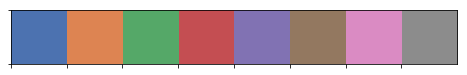

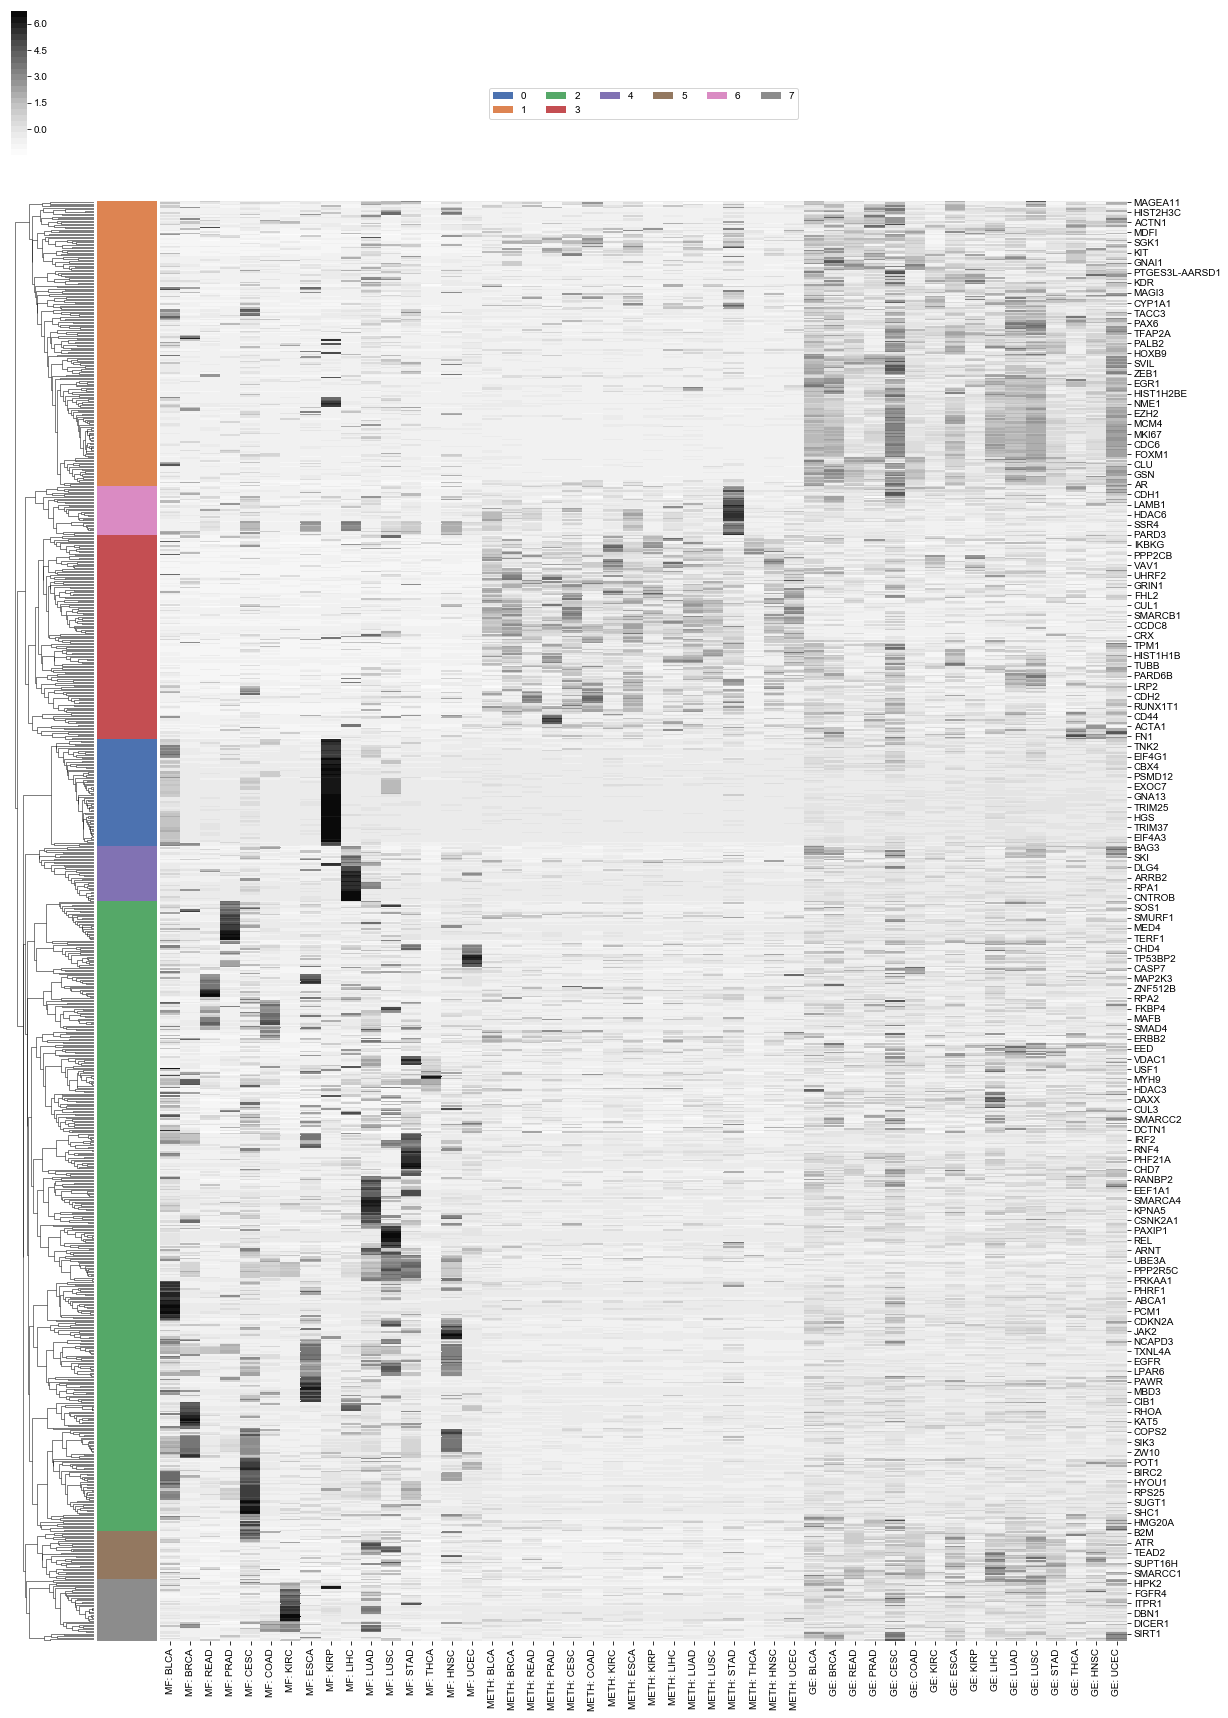

In [6]:
feat_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
high_feat = feat_df[feat_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
#high_feat = high_feat[high_feat.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes for Hierarchical Clustering".format(high_feat.shape[0]))

# compute the linkage matrix prior to the seaborn clustermap
from sklearn import preprocessing
Z_highconf = hierarchy.linkage(preprocessing.StandardScaler().fit_transform(high_feat), method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z_highconf, n_clusters=8)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(),
                       sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols_highconf = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat.shape[0])
onco_tsg_annotation[high_feat.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering

clu = sns.clustermap(high_feat,
                     row_linkage=Z_highconf,
                     z_score=0, # axis 0
                     #standard_scale=0,
                     metric='euclidean',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=7,
                     row_colors=[flat_rowcols_highconf],
                     #robust=True,
                     cmap=sns.color_palette("Greys", n_colors=25)
                    )

# plot the cluster indices as legend
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)

#clu.savefig(os.path.join(model_dir, 'clustering_lrp_highconf.png'), dpi=300)

## Heatmap to visualize clusters of important features

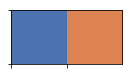

In [6]:
# compute the linkage matrix prior to the seaborn clustermap
Z = hierarchy.linkage(feat_contrib_df, method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z, n_clusters=2)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(), sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

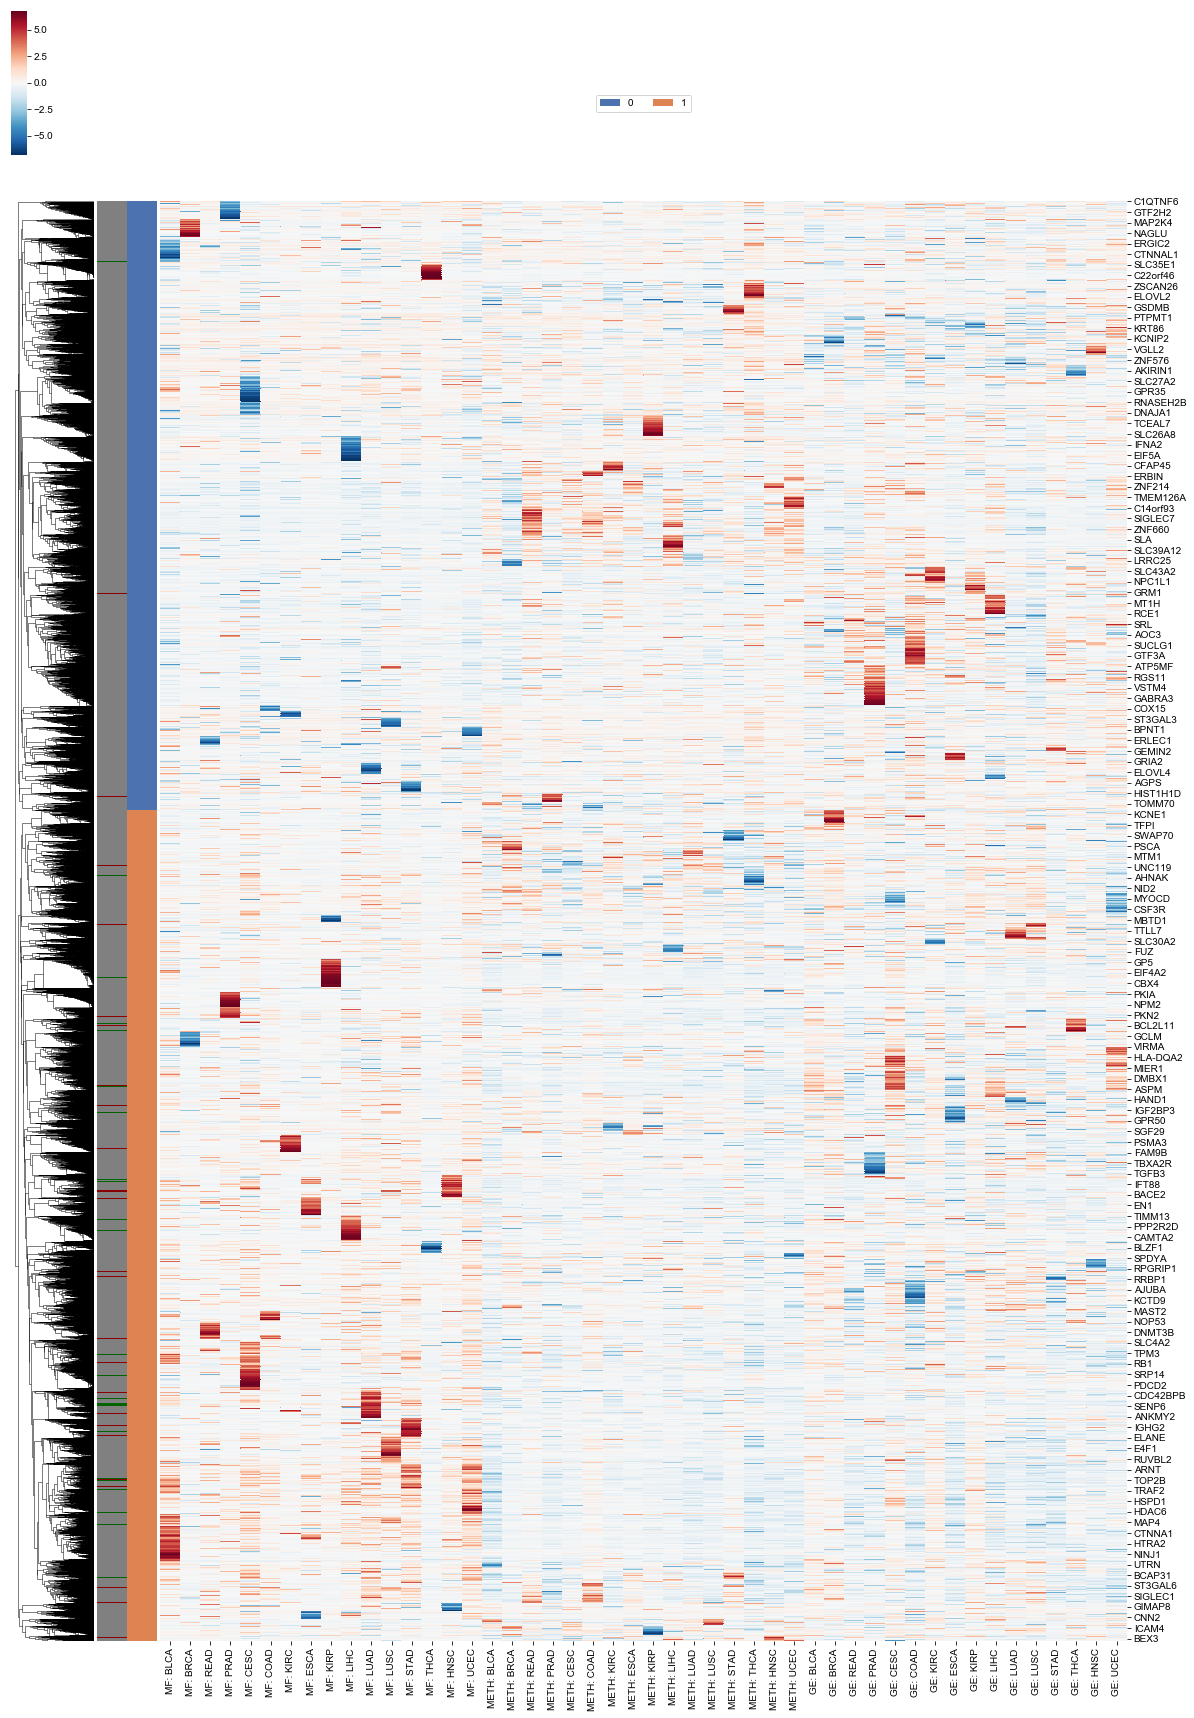

In [8]:
sys.setrecursionlimit(10000)

# get the literature information on known cancer genes
"""
oncokb, known, candidate = get_cancer_genes()
arr = np.zeros(feat_contrib_df.shape[0])
arr[feat_contrib_df.index.isin(known)] = 1
arr[feat_contrib_df.index.isin(candidate)] = 2
#arr[feat_contrib_df.index.isin(oncokb['Hugo Symbol'])] = 3
df = pd.Series(arr, index=feat_contrib_df.index, name='Literature Knowledge')
"""
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(feat_contrib_df.shape[0])
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=feat_contrib_df.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering
clu = sns.clustermap(feat_contrib_df,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='correlation',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=100,
                     row_colors=[row_colors, flat_rowcols],
                     cmap="RdBu_r"
                    )
# put in a fake legend that shows clusters
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)
clu.savefig(os.path.join(model_dir, 'clustering_lrp_allgenes.png'), dpi=300)

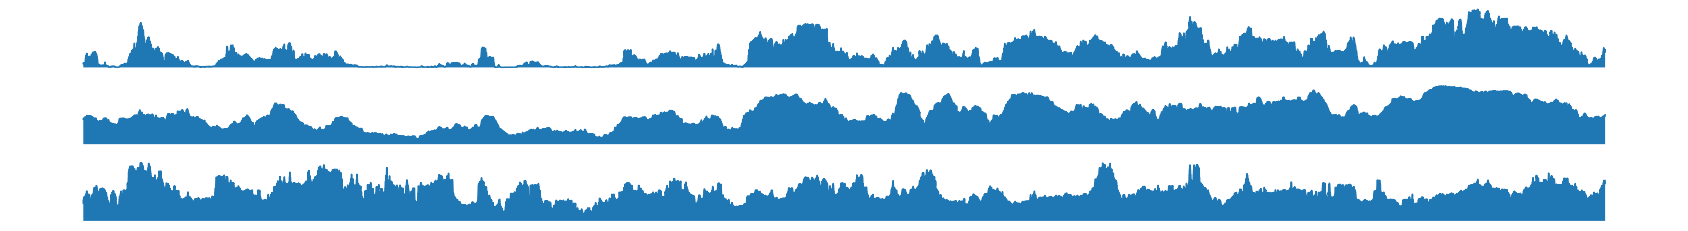

In [9]:
feature_contribution_sum = pd.Series(feat_contrib_df.sum(axis=1), name='Feature_Sum')
feat_contrib_predictions = pred.join(feature_contribution_sum, on='Name')
feat_contrib_predictions['Diff'] = feat_contrib_predictions.Feature_Sum / (feat_contrib_predictions.Prob_pos + 0.0001)
feat_contrib_predictions['Idx_Num'] = range(feat_contrib_predictions.shape[0])

feature_contribs_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Feature_Sum']
predictions_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Prob_pos']
diff_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Diff']




fig = plt.figure(figsize=(30, 4))
ax = plt.subplot(3, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex)
ax = plt.subplot(3, 1, 2)
plot_rolling_avg(ax, predictions_dendroindex)
ax = plt.subplot(3, 1, 3)
plot_rolling_avg(ax, diff_dendroindex)
fig.savefig(os.path.join(model_dir, 'feature_contribution_density_allgenes.png'), dpi=300)

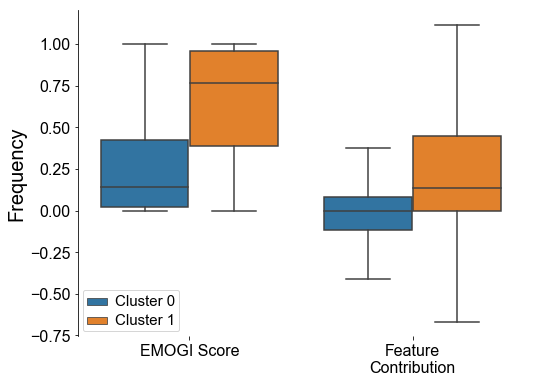

In [10]:
n_clusters_boxplots = 2
feat_vs_node = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=n_clusters_boxplots) # the first cluster are mutation driven, the second not

cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

feat_vs_node_series = pd.Series(feat_vs_node.reshape(-1))
nodes_with_cluster = nodes.copy()
nodes_with_cluster['Cluster'] = feat_vs_node
nodes_cluster_pred = nodes_with_cluster.join(pred.drop('Name', axis=1), on='ID').set_index('Name')
nodes_enriched = nodes_cluster_pred.join(feat_contrib_df.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

fig = plt.figure(figsize=(8, 6))
g = sns.boxplot(data=pd.melt(nodes_enriched.drop(['label', 'Std_Pred', 'Num_Pos'], axis=1), id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(['EMOGI Score', 'Feature\nContribution'])
fig.savefig(os.path.join(model_dir, '{}_clusters_difference_allgenes.svg'.format(n_clusters_boxplots)))

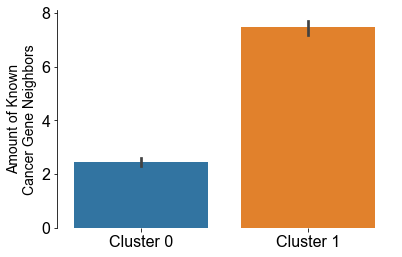

In [11]:
fig = plt.figure(figsize=(6, 4))
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
sns.barplot(data=nodes_enriched.join(num_known_neighbors)[['Cluster', 'Num_Cancer_Gene_Neighbors']], x='Cluster', y='Num_Cancer_Gene_Neighbors')
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Amount of Known\nCancer Gene Neighbors', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_cancerneighbors_allgenes.svg'.format(n_clusters_boxplots)))

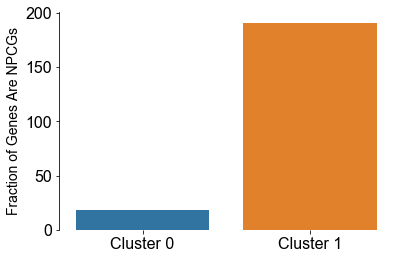

In [12]:
fig = plt.figure(figsize=(6, 4))
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes Are NPCGs', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_npcgs_allgenes.svg'.format(n_clusters_boxplots)))

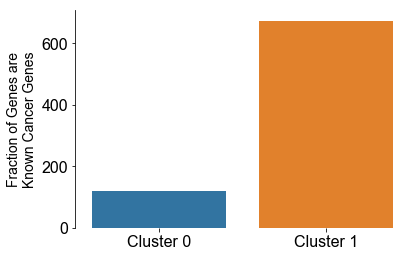

In [13]:
fig = plt.figure(figsize=(6, 4))
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes are\nKnown Cancer Genes', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_literature_allgenes.svg'.format(n_clusters_boxplots)))

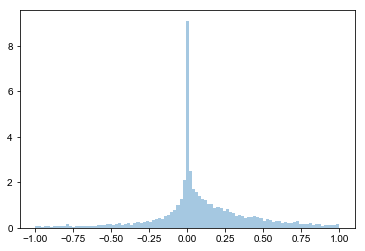

In [14]:
bins = np.linspace(-1, 1, 100)
sns.distplot(feat_contrib_df.sum(axis=1), bins=bins, kde=False, hist_kws={'density': True})
#plt.xlim([-10, 10])

## Compute Cluster Representatives and Pathway Enrichment

In [15]:
cluster_pathway_information = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathway_information.append((cluster_number, top_pathways))

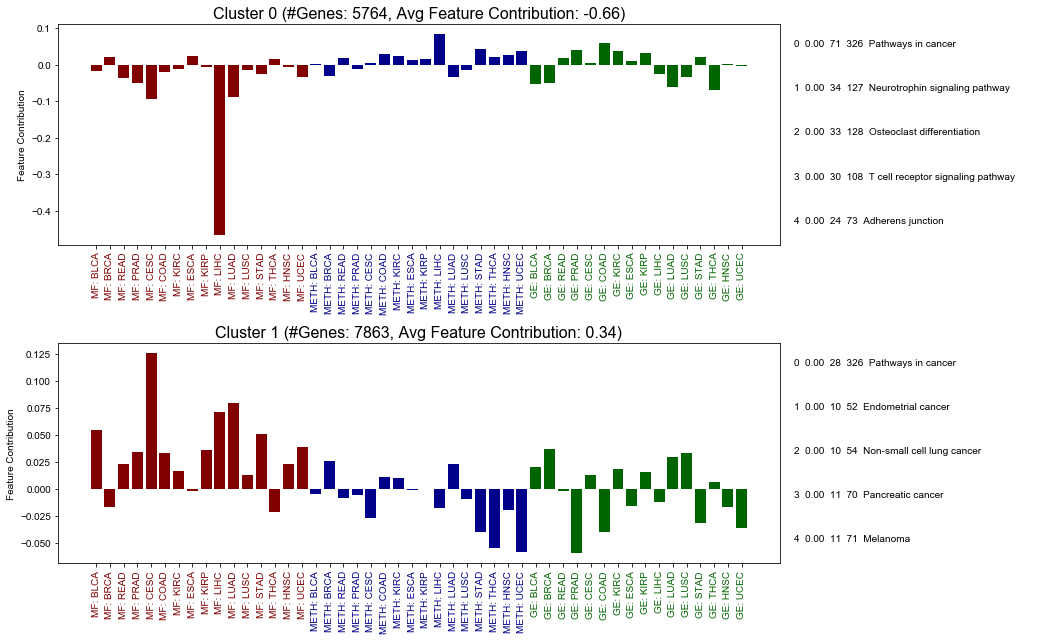

In [19]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = feat_contrib_df.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
                        title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                                    cluster_genes.shape[0],
                                                                                                    representative.sum()
                                                                                                   )
                       )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathway_information[cluster_number][1])
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_representatives_{}.pdf'.format(flat_clusters_series.nunique())))

## Repeat Clustering for Feature-Driven Genes

Selected 999 Genes again for Hierarchical Clustering


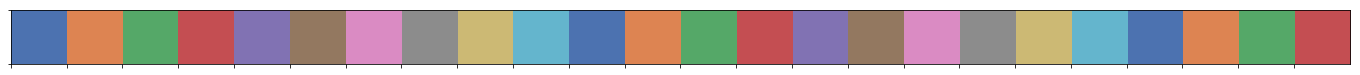

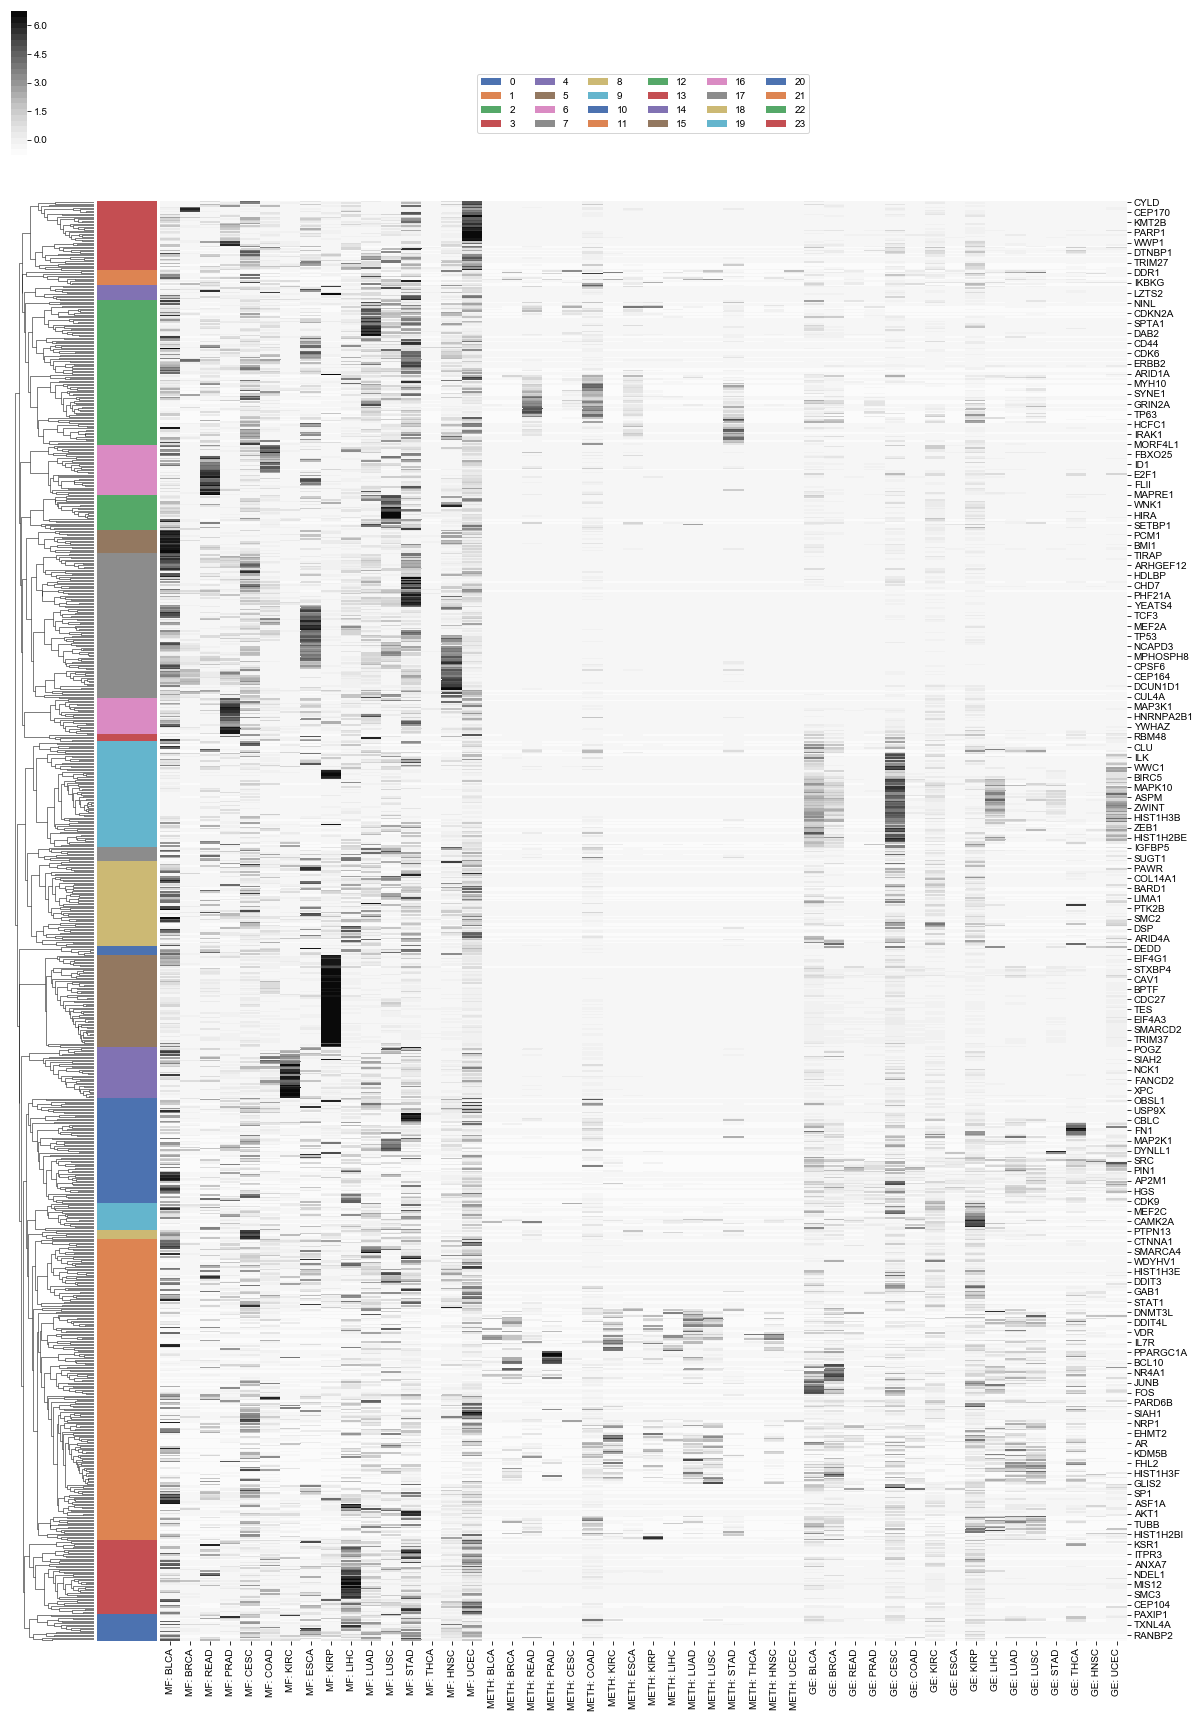

In [7]:
high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
high_feat_contrib = high_feat_contrib[high_feat_contrib.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes again for Hierarchical Clustering".format(high_feat_contrib.shape[0]))

# compute the linkage matrix prior to the seaborn clustermap
from sklearn import preprocessing
Z_highconf = hierarchy.linkage(preprocessing.StandardScaler().fit_transform(high_feat_contrib), method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z_highconf, n_clusters=24)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(),
                       sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols_highconf = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering
high_feat_contrib_capped = high_feat_contrib.copy()
high_feat_contrib_capped[high_feat_contrib_capped < 0] = 0

clu = sns.clustermap(high_feat_contrib_capped,
                     row_linkage=Z_highconf,
                     z_score=0, # axis 0
                     #standard_scale=0,
                     metric='euclidean',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=7,
                     row_colors=[flat_rowcols_highconf],
                     #robust=True,
                     cmap=sns.color_palette("Greys", n_colors=25)
                    )

# plot the cluster indices as legend
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)

#clu.savefig(os.path.join(model_dir, 'clustering_lrp_highconf.png'), dpi=300)

Optimal number of row clusters [17  1 30  2 36]
Optimal number of col clusters [1 5 2 3 9]


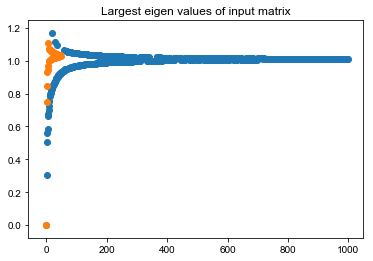

In [112]:


from scipy.spatial.distance import pdist, squareform

def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates))
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

from sklearn import metrics

def internalValidation(data, clusters):
    scores = {}
    """
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
    Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    """
    scores['_silhouette_score'] =metrics.silhouette_score(data,clusters ,metric='euclidean')
    """
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute
    """
    scores['_calinski_harabaz_score'] = metrics.calinski_harabaz_score(data,clusters)
    """
    Zero is the lowest possible score. Values closer to zero indicate a better partition.
    The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, 
    such as density based clusters like those obtained from DBSCAN.
    """
    scores['_davies_bouldin_score'] = metrics.davies_bouldin_score(data,clusters)
    return scores


affinity_matrix = getAffinityMatrix(high_feat_contrib_normed, k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix, plot=True)
print(f'Optimal number of row clusters {k}')

aff_mat_cols = getAffinityMatrix(high_feat_contrib_normed.T, k = 3)
k_col, _,  _ = eigenDecomposition(aff_mat_cols, plot=True)
print(f'Optimal number of col clusters {k_col}')

In [8]:
scores = []
combinations = []
for num_row_clusters in range(10, 30):
    for num_col_clusters in range(5, 20):
        #print (num_row_clusters, num_col_clusters)
        model = SpectralBiclustering(n_clusters=(num_row_clusters, num_col_clusters), method='bistochastic',
                                     svd_method='randomized', n_jobs=-1#, random_state=0
                                    )
        model.fit(high_feat_contrib_normed)
        score = metrics.silhouette_score(high_feat_contrib_normed, model.row_labels_ ,metric='euclidean')
        combinations.append((num_row_clusters, num_col_clusters))
        scores.append(score)

NameError: name 'SpectralBiclustering' is not defined

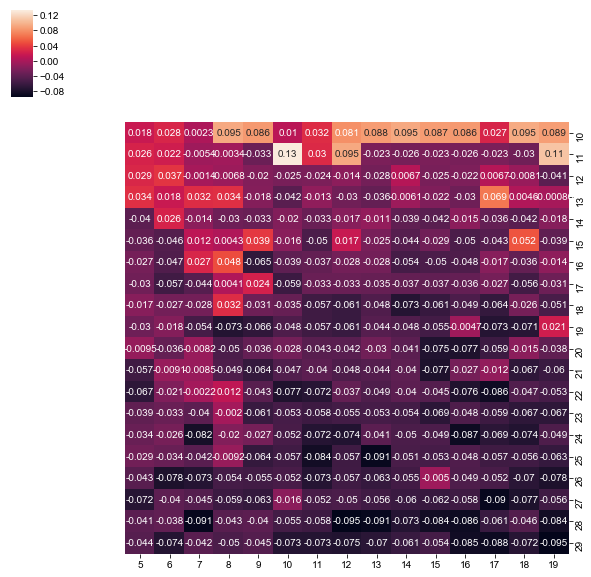

In [158]:
x = np.zeros((pd.Series(([i[0] for i in combinations])).nunique(),
              pd.Series(([i[1] for i in combinations])).nunique())
            )
x = pd.DataFrame(x, index=range(10, 30), columns=range(5, 20))
for i in range(len(combinations)):
    x.loc[combinations[i][0], combinations[i][1]] = scores[i]
sns.clustermap(x, method=None, row_cluster=False, col_cluster=False, annot=True)

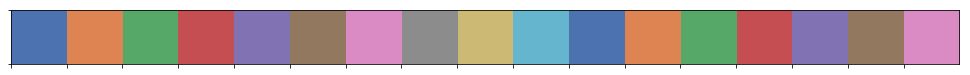

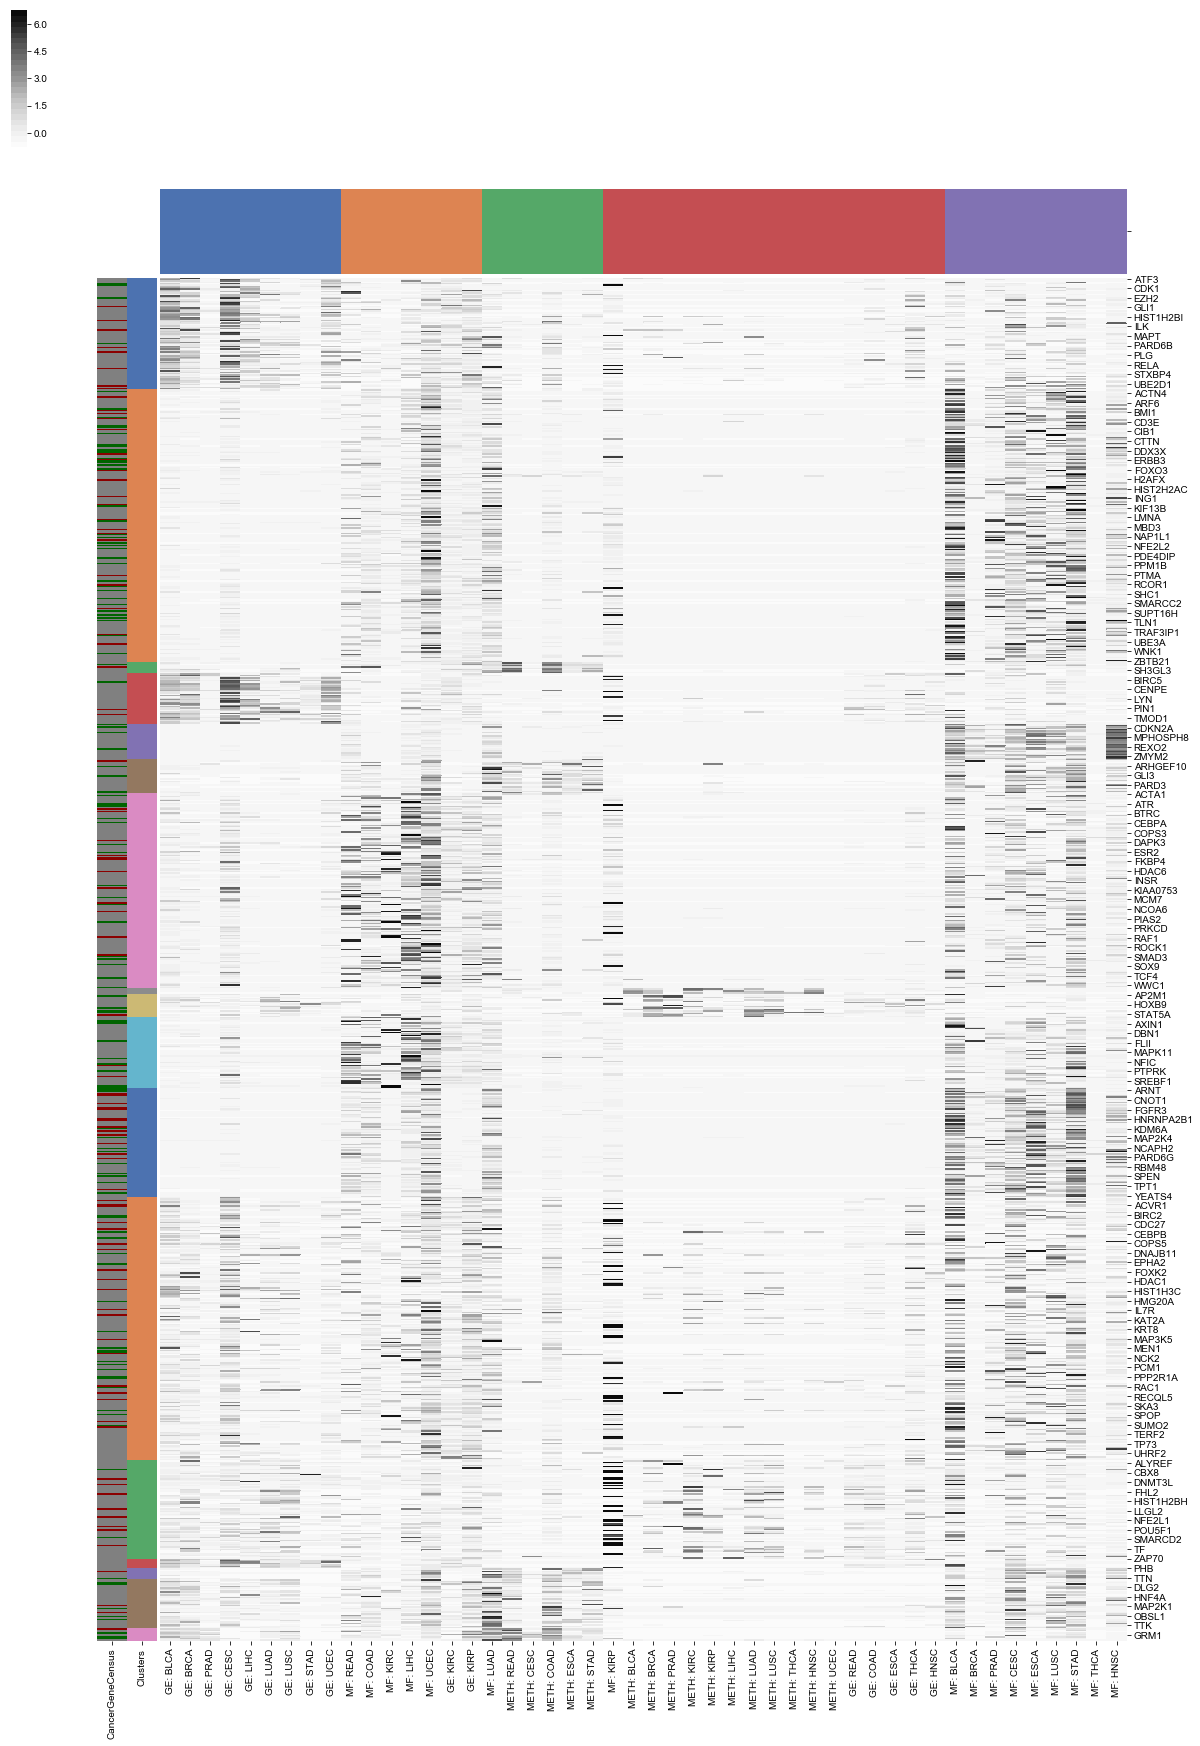

In [9]:
from sklearn.cluster import SpectralBiclustering

n_clusters = (17, 5)
high_feat_contrib_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(high_feat_contrib_capped),
                                        index=high_feat_contrib.index, columns=high_feat_contrib.columns)

model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1#, random_state=0
                            )
model.fit(high_feat_contrib_normed)
newOrder_row = [list(r) for r in zip(model.row_labels_, high_feat_contrib_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, high_feat_contrib_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = high_feat_contrib_capped.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns
X_plot.head()

lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=high_feat_contrib.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=high_feat_contrib.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=0, robust=False
                 )
cm.savefig(os.path.join(model_dir, 'biclustering_lrp_highconf.png'), dpi=300)

In [10]:
internalValidation(high_feat_contrib_normed, model.row_labels_)

NameError: name 'internalValidation' is not defined

In [ ]:
high_feat_contrib.iloc[model.get_indices(0*n_clusters[0]+12)].index.contains('APC')

In [ ]:
pd.Series(model.row_labels_, index=high_feat_contrib.index)['EGFR']

In [164]:
cluster_pathways_highconf = []
for cluster_number in range(n_clusters[0]):
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number*n_clusters[1])]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    top_pathways = get_pathway_enrichment(genes, cluster_number, model_dir)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

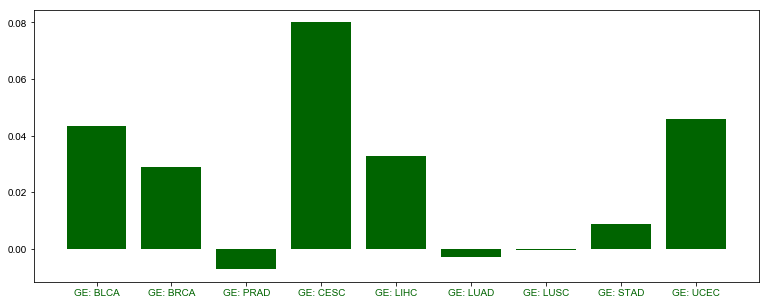

In [80]:
c_row, c_col = (9, 3)

# find the genes in the current cluster
subcluster = high_feat_contrib.iloc[model.get_indices(c_row*n_clusters[1]+c_col)]
genes = nodes[nodes.Name.isin(subcluster.index)]

# compute the representative for that cluster
representative = subcluster.mean(axis=0)

sum_of_all = 0
fig, axes = plt.subplots(nrows=n_clusters[0], ncols=2,
                         figsize=(15, n_clusters[0]*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

for cluster_number in range(n_clusters[0]):
    # find the genes in the current cluster
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number*n_clusters[1])]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib[high_feat_contrib.index.isin(genes.Name)]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, v,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

ax.set_ylabel('Feature Contribution')
utils.colorize_by_omics(plt.gca(), xlabels)

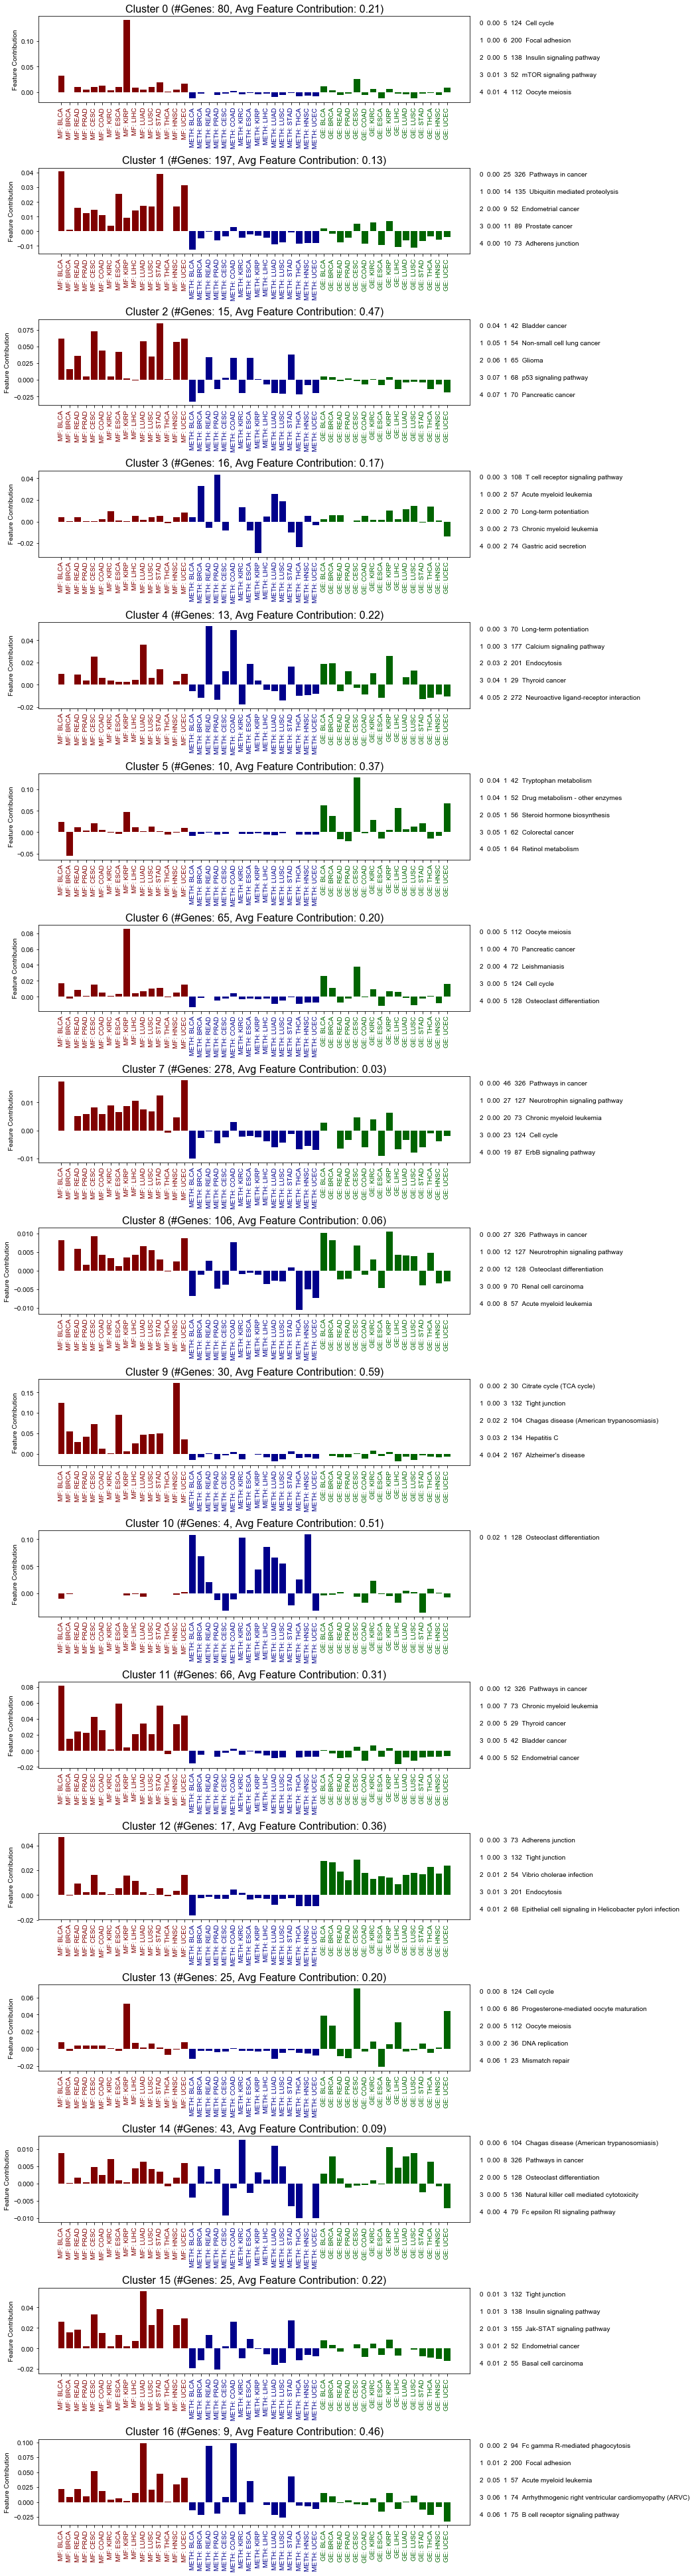

In [172]:
sum_of_all = 0
fig, axes = plt.subplots(nrows=n_clusters[0], ncols=2,
                         figsize=(15, n_clusters[0]*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in range(n_clusters[0]):
    # find the genes in the current cluster
    subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number*n_clusters[1])]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib[high_feat_contrib.index.isin(genes.Name)]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, v,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

In [ ]:
feature_contribution_sum = pd.Series(high_feat_contrib.sum(axis=1), name='Feature_Sum')
feature_contribs_dendroindex = feature_contribution_sum[clu.dendrogram_row.reordered_ind]

fig = plt.figure(figsize=(30, 1))
ax = plt.subplot(1, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex, window_size=30)
fig.savefig(os.path.join(model_dir, 'feature_contribution_density_highconf.png'), dpi=300)

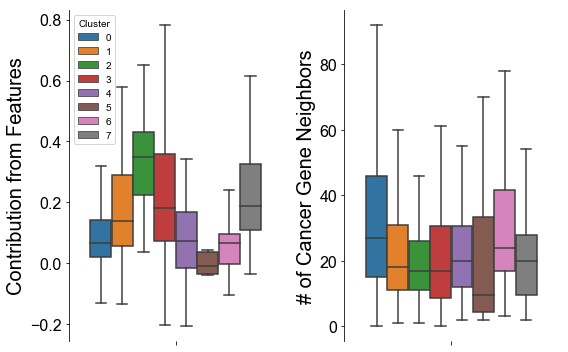

In [25]:
n_clusters_boxplots = 8
clusters = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=n_clusters_boxplots)

cluster_label_list = ['Cluster {}'.format(i+1) for i in range(n_clusters_boxplots)]

nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = clusters

# put in the amount of feature contribution
nodes_highconf_pred = nodes_highconf.join(pred.set_index('Name'))
nodes_enriched = nodes_highconf_pred.join(high_feat_contrib.sum(axis=1).rename('Feature_Contribution'))

# put in the labels (known cancer genes)
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

# put in number of cancer neighbors
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
nodes_enriched = nodes_enriched.join(num_known_neighbors)

# put in the number of NPCGs per cluster
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]

# plot
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)

# start with boxplot of feature contributions
g = sns.boxplot(data=pd.melt(nodes_enriched[['Feature_Contribution', 'Cluster']], id_vars=['Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
#g.legend().remove()
plt.xlabel(None)
plt.ylabel('Contribution from Features', fontsize=20)
#h,l = g.get_legend_handles_labels()
#g.legend_.remove()
#g.legend(h,cluster_label_list, ncol=4, fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])

# next, plot the number of known cancer gene neighbors
plt.subplot(1, 2, 2)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='variable', y='value', hue='Cluster', showfliers=False)
g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])
plt.ylabel('# of Cancer Gene Neighbors', fontsize=20)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_stats_{}_boxplots.svg').format(n_clusters_boxplots))

In [7]:
nodes_enriched[nodes_enriched.index == 'REG3A']

NameError: name 'nodes_enriched' is not defined

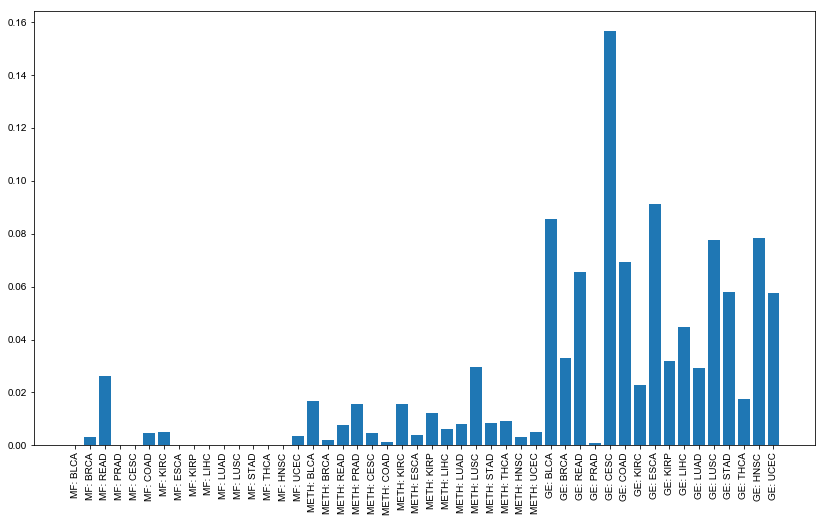

In [8]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=features_df[features_df.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(features_df.shape[1])), labels=features_df.columns, rotation=90)

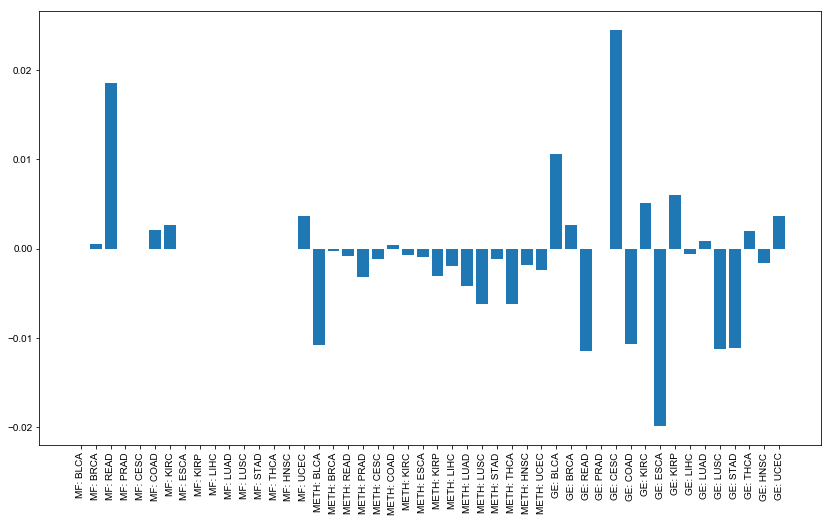

In [9]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=high_feat_contrib[high_feat_contrib.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(high_feat_contrib.shape[1])), labels=high_feat_contrib.columns, rotation=90)

In [10]:
high_feat_contrib.iloc[:, 16:32].mean(axis=1).sort_values(ascending=False).head()

REG3A    0.044
REG1B    0.038
HAVCR1   0.034
LILRB2   0.030
TLX3     0.021
dtype: float64

In [12]:
#high_feat_contrib.iloc[:, 16:32].mean().sort_values(ascii).head()

In [13]:
cluster_pathways_highconf = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

In [14]:
pd.reset_option('display.float_format')
cluster_pathways_highconf[4][1]

,Pvalue,Count,Size,Term
1,2.046324e-19,22,124,Cell cycle
2,1.966939e-10,14,112,Oocyte meiosis
3,1.913606e-07,10,86,Progesterone-mediated oocyte maturation
4,2.642778e-07,9,68,p53 signaling pathway
5,7.462776e-06,6,36,DNA replication


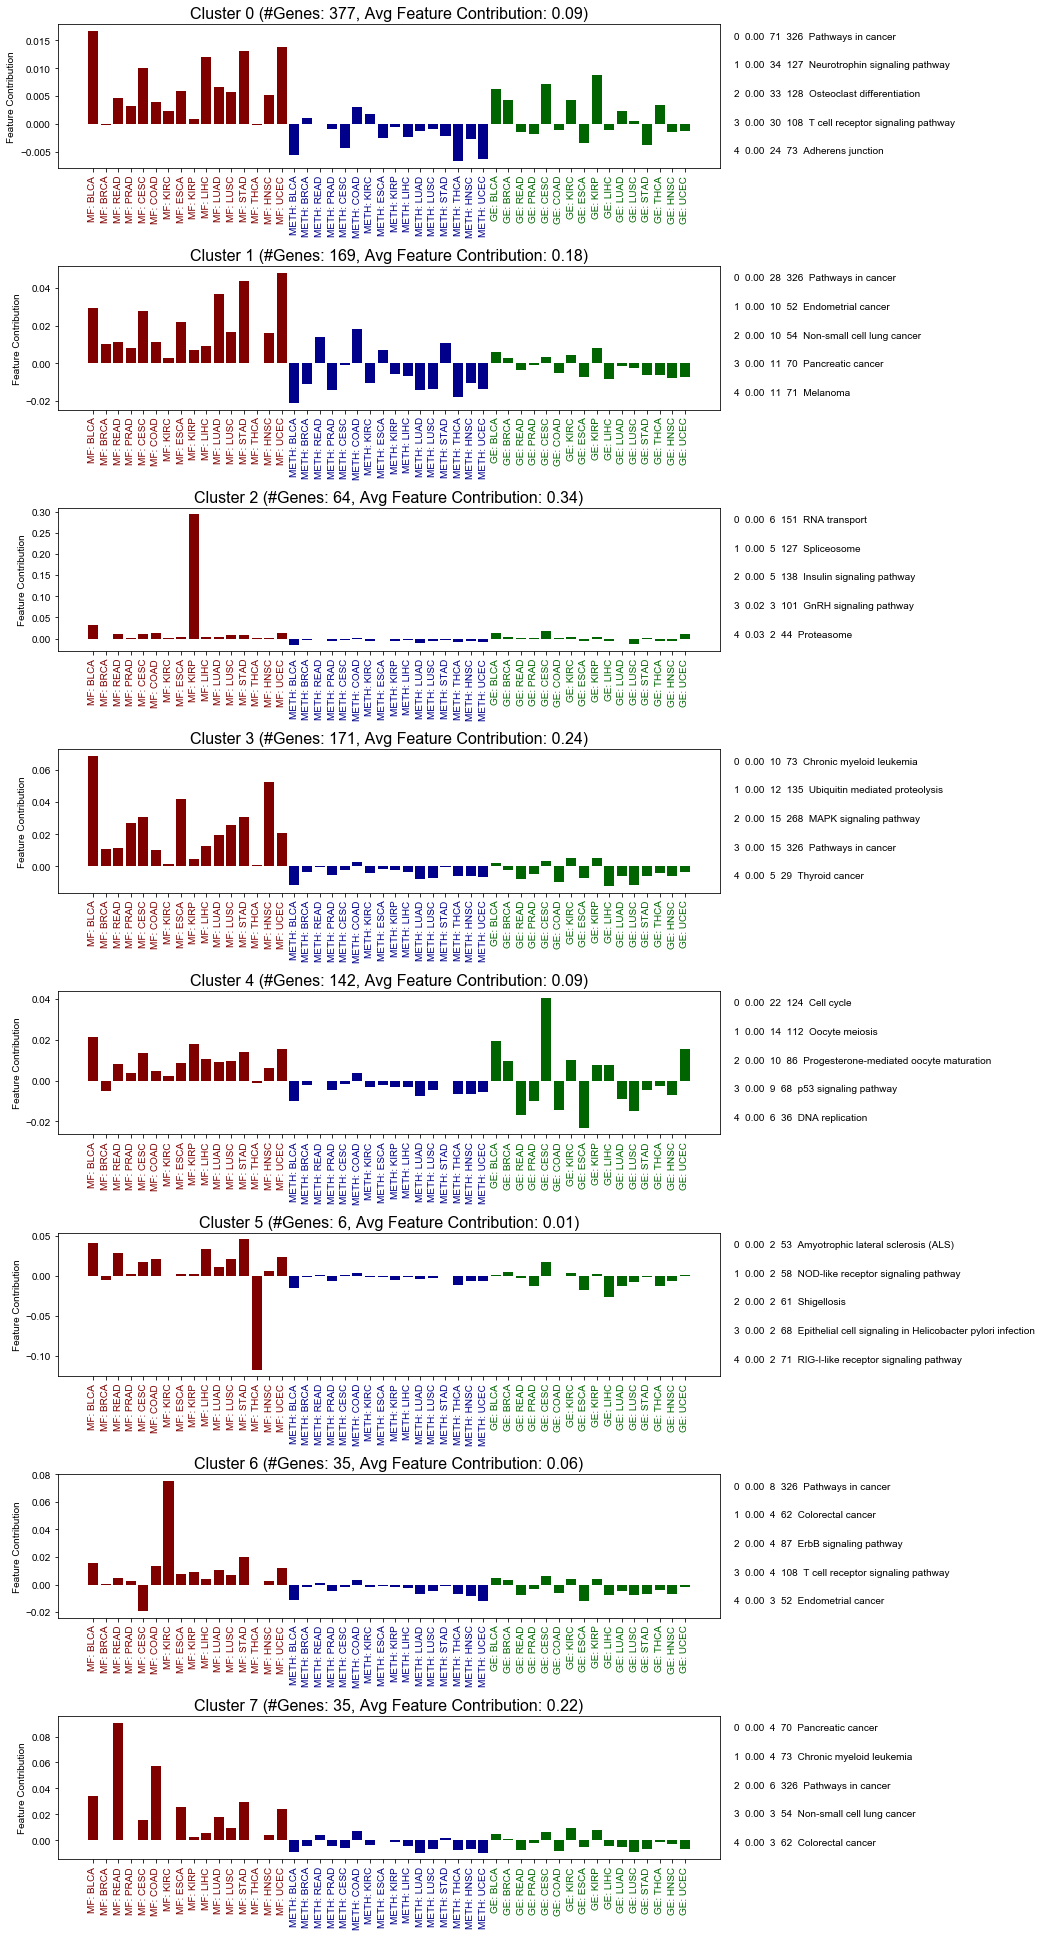

In [15]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         cluster_genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

(48,)
Max and min  0.09082470211599554 0.00022232883077647004
(16, 3)
(1, 3)
(16, 3)
(1, 3)
(16, 3)
(1, 3)


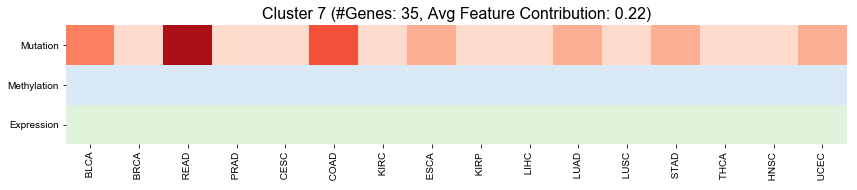

In [138]:
cluster_num = 7
indices = flat_clusters_series[flat_clusters_series == cluster_num].index
contribs = high_feat_contrib.iloc[indices]
rep = contribs.mean(axis=0)

fig = plt.figure(figsize=(14, 2))
ax = plt.subplot(1, 1, 1)
utils.lrp_heatmap_plot(fig, ax, rep.values, rep.index,
                       title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_num, indices.shape[0], rep.sum())
                      )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig(os.path.join(model_dir, 'cluster_{}_heatmap.svg'.format(cluster_num)))

In [96]:
gene_name = 'COIL'

cluster_number = flat_clusters_series[clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == gene_name].index)]
cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
cluster_genes = nodes[nodes.index.isin(cluster_gene_indices)]
print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
#cluster_genes.to_csv(os.path.join(model_dir, 'cluster_{}_gene_{}.tsv'.format(cluster_number, gene_name)), sep='\t')

Cluster 2 contains 3893 genes


In [108]:
start_gene = 'HDC'
end_gene = 'STIM1'
start_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == start_gene].index)
end_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == end_gene].index)
print (start_idx, end_idx)
relevant_indices = clu.dendrogram_row.reordered_ind[start_idx:end_idx]
relevant_indices
nodes[nodes.index.isin(relevant_indices)].set_index('ID')#.to_csv(os.path.join(model_dir, 'interesting_cluster_{}_{}.tsv'.format(start_gene, end_gene)), sep='\t')

10550 10573


,Name
ID,
ENSG00000162458,FBLIM1
ENSG00000130164,LDLR
ENSG00000086730,LAT2
ENSG00000177971,IMP3
ENSG00000099901,RANBP1
ENSG00000089127,OAS1
ENSG00000181804,SLC9A9
ENSG00000184939,ZFP90
ENSG00000165092,ALDH1A1


## Are Newly Predicted Cancer Genes Interaction or Feature Driven?

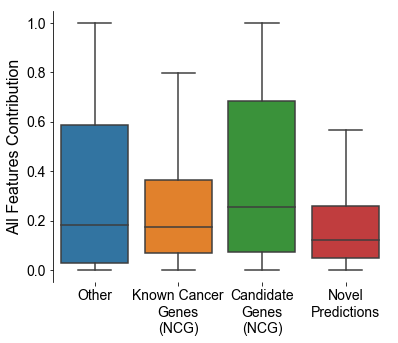

In [16]:
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
oncokb, known, candidate = get_cancer_genes()
npcgs.set_index('Name', inplace=True)
contribution_sum_df = pd.DataFrame(feat_contrib_df.sum(axis=1), columns=['Feature_Sum'])
contribution_sum_df['Gene_Set'] = 'Other'
#contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nCancer Gene'
#contribution_sum_df.loc[contribution_sum_df.index.isin(oncokb['Hugo Symbol']), 'Gene_Set'] = 'OncoKB'
contribution_sum_df.loc[contribution_sum_df.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'
contribution_sum_df.Gene_Set.value_counts()
contribution_sum_df.Feature_Sum = contribution_sum_df.Feature_Sum.abs()
contribution_sum_df.loc[contribution_sum_df.Feature_Sum > 1, 'Feature_Sum'] = 1

fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=contribution_sum_df, x='Gene_Set', y='Feature_Sum', showfliers=False, 
            order=['Other', 'Known Cancer\nGenes\n(NCG)', 'Candidate\nGenes\n(NCG)', 'Novel\nPredictions'])
plt.ylabel('All Features Contribution', fontsize=16)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(model_dir, 'feature_contribution_npcgs.svg'))

In [17]:
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum(axis=1).T

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

omics_contributions_probs = omics_contributions.apply(softmax, axis=1)

In [39]:
omics_contributions_probs['Gene_Set'] = 'Other'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), 'Gene_Set'] = 'Top 1000\nPredictions'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'

In [40]:
omics_contributions_probs.Gene_Set.value_counts()

Other                         11068
Candidate\nGenes\n(NCG)        1094
Top 1000\nPredictions           851
Known Cancer\nGenes\n(NCG)      405
Novel\nPredictions              209
Name: Gene_Set, dtype: int64

In [41]:
assert ((omics_contributions_probs.index == contribution_sum_df.index).all())
omics_contributions_highconf = omics_contributions_probs[contribution_sum_df.Feature_Sum > 0.25]
omics_contributions_highconf.shape

(5932, 4)

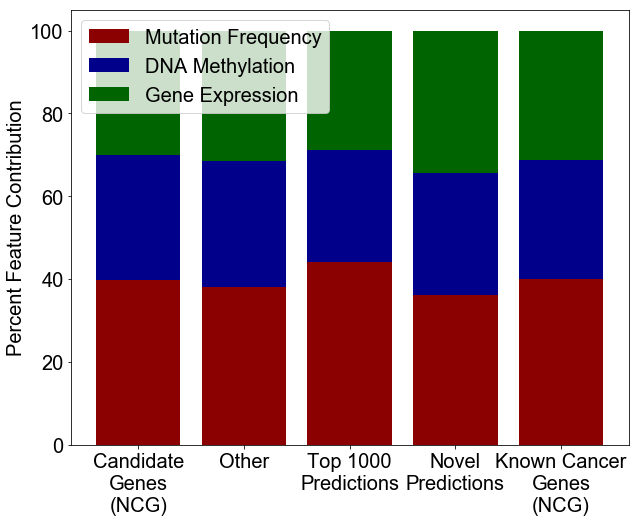

In [42]:
stacked_barplot_vals = {}
gene_sets = omics_contributions_highconf.Gene_Set.unique()
groups = list(range(len(gene_sets)))
for omics in ['MF', 'METH', 'GE']:
    omics_vals = []
    for gene_set in gene_sets:
        omics_vals.append(omics_contributions_highconf.loc[omics_contributions_highconf.Gene_Set == gene_set, omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k for i,j,k in zip(df['MF'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, methylation_bars, bottom=mutation_bars, color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j for i,j in zip(mutation_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, gene_sets, fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
fig.savefig(os.path.join(model_dir, 'omics_contributions_genesets.svg'))

In [31]:
stacked_barplot_vals

{'MF': [0.3973279418247757,
  0.38199316511189624,
  0.4422618849351148,
  0.3607138213970697,
  0.3996129715142591],
 'METH': [0.3023134653534761,
  0.3044165647786206,
  0.27050331338807954,
  0.2948816493590533,
  0.2890455529851608],
 'GE': [0.30035859282174826,
  0.3135902701094844,
  0.28723480167680576,
  0.34440452924387693,
  0.31134147550057995]}

## Are the NPCGs Housekeeping Genes?

## Neighbor Contribution

In [24]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)
lrp_neighbor_matrix.min(), lrp_neighbor_matrix.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-1133.4231487286886, 605.889359749145)

In [25]:
lrp_neighbor_matrix_abs = np.abs(lrp_neighbor_matrix)
C_abs = nx.from_pandas_adjacency(pd.DataFrame(lrp_neighbor_matrix_abs, index=node_names[:, 1], columns=node_names[:, 1]), create_using=nx.MultiDiGraph)

def get_number_of_modules(threshold):
    to_remove = []
    for u, v, weight in C_abs.edges(data='weight'):
        if weight < threshold:
            to_remove.append((u, v))
    C_abs_copy = C_abs.copy()
    C_abs_copy.remove_edges_from(to_remove)
    module_sizes = [len(c) for c in sorted(nx.strongly_connected_components(C_abs_copy), key=len, reverse=True) if len(c) > 5]
    return len(module_sizes)

In [26]:
thresholds = np.arange(0.1, 2.01, 0.1)
number_of_modules = []
for thr in thresholds:
    number_of_modules.append(get_number_of_modules(thr))

In [28]:
number_of_modules

[3, 5, 4, 9, 8, 9, 9, 8, 8, 8, 8, 6, 5, 4, 4, 4, 2, 2, 2, 2]

[3, 5, 4, 9, 8, 9, 9, 8, 8, 8, 8, 6, 5, 4, 4, 4, 2, 2, 2, 2]


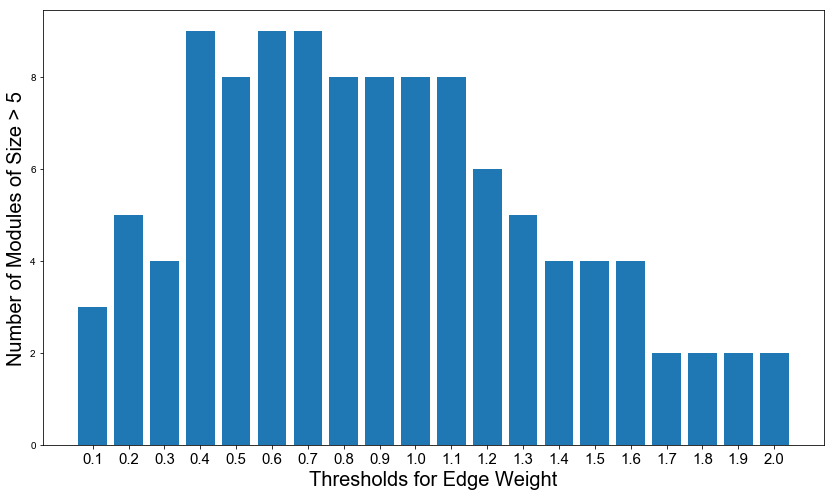

In [30]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(len(number_of_modules))), height=number_of_modules)
_ = plt.xticks(ticks=list(range(len(number_of_modules))), labels=['{0:.1f}'.format(i) for i in thresholds], fontsize=15)
plt.xlabel('Thresholds for Edge Weight', fontsize=20)
plt.ylabel('Number of Modules of Size > 5', fontsize=20)
print (number_of_modules)

In [36]:
min_edge_weight = 1.1

nw_thr = np.where(np.abs(lrp_neighbor_matrix) <= min_edge_weight, 0, lrp_neighbor_matrix)
nw_thr.nonzero()[0].shape, lrp_neighbor_matrix.nonzero()[0].shape

((9084,), (517996,))

In [37]:
nw_thr_df = pd.DataFrame(data=nw_thr, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nw_thr_df, create_using=nx.MultiDiGraph)
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
print ([len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(G), key=len)))
nodes_component = list(max(nx.strongly_connected_components(G), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1]

[22, 12, 11, 7, 7, 6, 6, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
22


In [38]:
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
for i in range(5):
    fname = os.path.join(model_dir, 'lrp_neighbors_comp_{}_thr_{}.gml'.format(i+1, min_edge_weight))
    comp = all_components[i]
    nx.write_gml(G.subgraph(comp), path=fname)
    fname_nodes = os.path.join(model_dir, 'lrp_neighbors_comp_{}_thr_{}_nodes.csv'.format(i+1, min_edge_weight))
    node_names_df[node_names_df.Name.isin(comp)].to_csv(fname_nodes, sep='\t')
    print ("Graph written to: {}".format(fname))

Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_comp_1_thr_1.1.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_comp_2_thr_1.1.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_comp_3_thr_1.1.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_comp_4_thr_1.1.gml
Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_comp_5_thr_1.1.gml


In [ ]:
pathway_sccs = []
for i in range(5):
    pathway_sccs.append(get_pathway_enrichment())

## LRP Neighbor Contributions Introduce no New Interactions

In [4]:
import lrp

W0128 15:08:03.968242 140717080004224 deprecation_wrapper.py:119] From /project/gcn/src/deepexplain/deepexplain/tensorflow/methods.py:559: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [6]:
interpreter = lrp.LRP(model_dir=model_dir)

Calculating Chebyshev polynomials up to order 1...


In [52]:
lrp_scores = interpreter.compute_lrp('APC')
mean_feat, std_feat, mean_neighbors, std_neighbors = lrp_scores

Now: APC


In [56]:
nn_contrib_s0 = pd.DataFrame(mean_neighbors[1], index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nn_contrib_s0)
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
G.remove_edges_from(G.selfloop_edges())
G.number_of_edges()

NameError: name 'mean_neighbors' is not defined

In [54]:
gene_name = 'APC'
contributers_tp53 = list(G.neighbors(gene_name))
same = 0
for neighbor in A.neighbors(gene_name):
    if not neighbor in contributers_tp53:
        print (neighbor)
    else:
        same += 1
same

194

In [55]:
A.number_of_edges(), G.number_of_edges()

(252189, 237795)

In [61]:
len(list(contrib_all.neighbors('APC')))

194

In [65]:

def edge_exists(source, target):
    if A.has_edge(source, target):

24.0

In [75]:
count = 0
for (u, v) in A.edges():
    count += 1
    if not contrib_all.has_edge(u, v):
        print (u, v)

MMP20 DSPP
C1QTNF1 C1QTNF6


In [74]:
A.number_of_edges(), G.number_of_edges(), contrib_all.number_of_edges()

(252189, 237795, 252187)

In [57]:
A = nx.from_pandas_adjacency(pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1]))
len(list(A.neighbors('ZHX2')))

32

In [54]:
feat_contrib_df[feat_contrib_df.sum(axis=1).abs() > 2.5].shape

(840, 48)

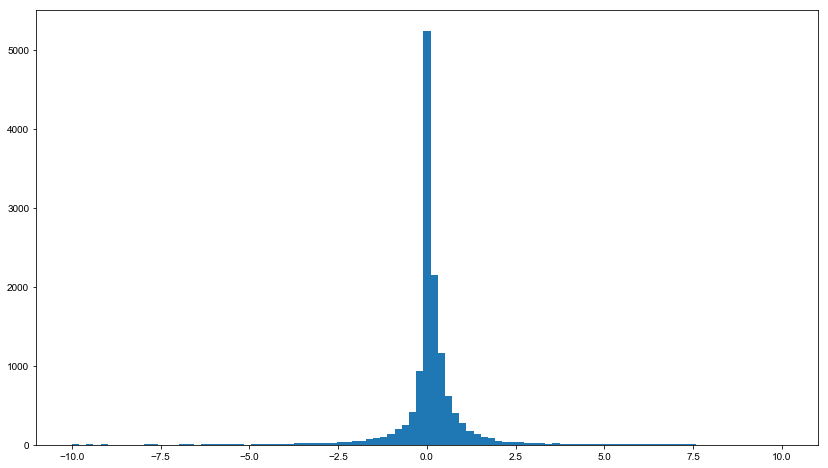

In [49]:
fig = plt.figure(figsize=(14, 8))
_= plt.hist(feat_contrib_df.sum(axis=1), bins=np.linspace(-10, 10, 100))